In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.io import wavfile
from scipy import signal
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Input, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, recall_score, accuracy_score, mean_squared_error, confusion_matrix, make_scorer

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline



pd.options.mode.chained_assignment = None

In [8]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (9, 12)


# 1 - Time to Frequency domain study

In [9]:
def plot_frequencies(filenames):
    for i in range(len(filenames)):
        freqs = convert_to_frequency(filenames[i])
        
        plt.subplot(len(filenames), 1, i+1)
        plt.plot(freqs[1], np.abs(freqs[2]), 'r')
        plt.xlabel("frequency, Hz")
        plt.ylabel("Amplitude, units")
        plt.title(filenames[i])

In [394]:
def convert_to_frequency(inp_filename):
    sampFreq, sound = wavfile.read(inp_filename)
    sound = sound / 2.0**15
    length_in_s = sound.shape[0] / sampFreq
    time = np.arange(sound.shape[0]) / sound.shape[0] * length_in_s
    signal = sound[:,0]
    
    fft_spectrum = np.fft.rfft(signal)
    freq = np.fft.rfftfreq(signal.size, d=1./sampFreq)
    
    fft_spectrum_abs = np.abs(fft_spectrum)
    
    return fft_spectrum, freq, fft_spectrum_abs, sampFreq

def apply_filter_to_fft(freq, fft_spectrum, freq_filter):
    fft_abs = np.abs(fft_spectrum)
    max_thresh = np.max(freq_filter)
    mid_val = np.max(fft_abs)
    for i,f in enumerate(freq):
        if fft_abs[i] < mid_val / 2:
            fft_spectrum[i] = np.round(fft_spectrum[i] * freq_filter[i] / 8)
        if fft_abs[i] >= mid_val / 2:
            fft_spectrum[i] = 0
            
        if f < 62 and f > 58: # (1)
            fft_spectrum[i] = 0.0
        if f < 21 or f > 20000: # (2)
            fft_spectrum[i] = 0.0
            

    return fft_spectrum
            
def revert_to_wav(filename, fft_spectrum, sampFreq):
    noiseless_signal = np.fft.irfft(fft_spectrum)
    wavfile.write(filename, sampFreq, noiseless_signal)
    

def boost_audio(inp_filename, original_filename, out_filename, freq_filter):
    print("Converting to fft")
    sample = convert_to_frequency(inp_filename)
    original = convert_to_frequency(original_filename)
    
    
    print("Creating filter", len(sample[0]))
    freq_filter = create_filter(sample[2])
    
    print("Filtering")
    fft_spectrum = apply_filter_to_fft(sample[1], sample[0], freq_filter)
    # For more on the scipy.signal API: https://docs.scipy.org/doc/scipy/reference/signal.html#window-functions
    #fft_spectrum = signal.fftconvolve(fft_spectrum, signal.windows.gaussian(50, 8), mode='same')
    
    print("plotting")
    plt.subplot(4,1,2)
    plt.plot(sample[1], np.abs(sample[2]), 'r')
    plt.subplot(4,1,2)
    plt.plot(sample[1], freq_filter, 'y')
    plt.xlabel("frequency, Hz")
    plt.ylabel("Amplitude, units")
    plt.subplot(4,1,3)
    plt.plot(original[1], np.abs(original[2]), 'b')
    plt.xlabel("frequency, Hz")
    plt.ylabel("Amplitude, units")
    plt.tight_layout()
    plt.subplot(4,1,4)
    plt.plot(sample[1], np.abs(fft_spectrum), 'g')
    plt.xlabel("frequency, Hz")
    plt.ylabel("Amplitude, units")
    plt.tight_layout()
    plt.show()
    
    revert_to_wav(out_filename, fft_spectrum, sample[3])

In [386]:
def create_filter(fft_spectrum):
    freq_filter = np.arange(len(fft_spectrum))
    #for i in range(len(freq_filter)):
    #    freq_filter[i] =  80.0 / (float(i+1)*0.1)
        
    freq_filter[:2200] = 8
    freq_filter[2200:12000] = 4
    freq_filter[12000:30000] = 2.5
    freq_filter[30000:65000] = 1.5
    freq_filter[65000:] = 1
        
    return freq_filter

In [124]:
freq_filter = np.arange(229377)
freq_filter[:2100] = 2
freq_filter[2100:6000] = 1
freq_filter[6000:10000] = 0.
freq_filter[10000:16000] = 30.0
freq_filter[14000:25000] = 17.0
freq_filter[25000:45000] = 10.0
freq_filter[45000:65000] = 7.0
freq_filter[65000:] = 5.0

print(freq_filter.shape)

conv_freq_filter = np.array([7, 26, 41, 26, 7])

(229377,)


In [136]:
np.sum((conv_freq_filter+0j) * (np.array([7/107, 26/107, 41/107, 26/107, 7/107])+1j))

(29.261682242990656+107j)

Text(0, 0.5, 'Amplitude, units')

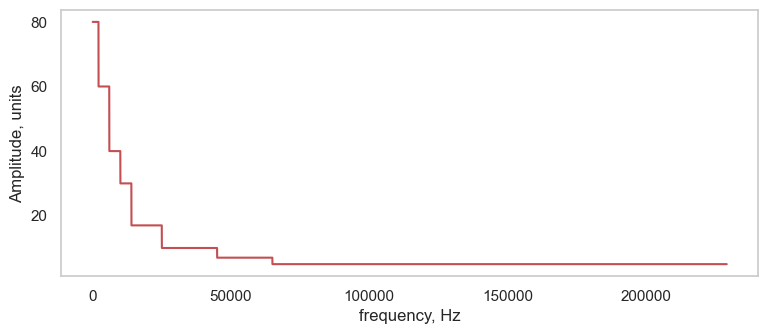

In [322]:
plt.subplot(3,1,1)
plt.plot(freq_filter, 'r')
plt.xlabel("frequency, Hz")

plt.ylabel("Amplitude, units")

Converting to fft
Creating filter 240129
(240129,) [8 8 8 ... 1 1 1] 1
Filtering


<ipython-input-394-eec78af3fbf5>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)


plotting


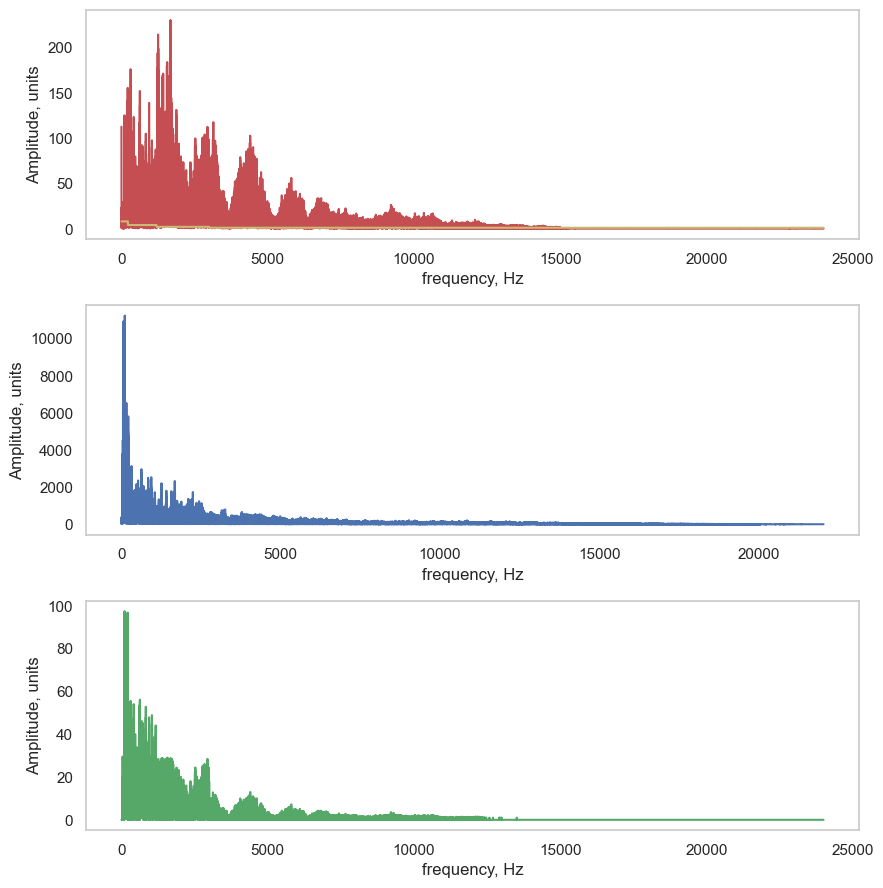

In [401]:
boost_audio('data/sample_1.wav', 'data/cut_original.wav', 'data/noiseless_sample_boosted1.wav', freq_filter)

Converting to fft
Creating filter 240641
(240641,) [8 8 8 ... 1 1 1] 1
Filtering


<ipython-input-394-eec78af3fbf5>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)


plotting


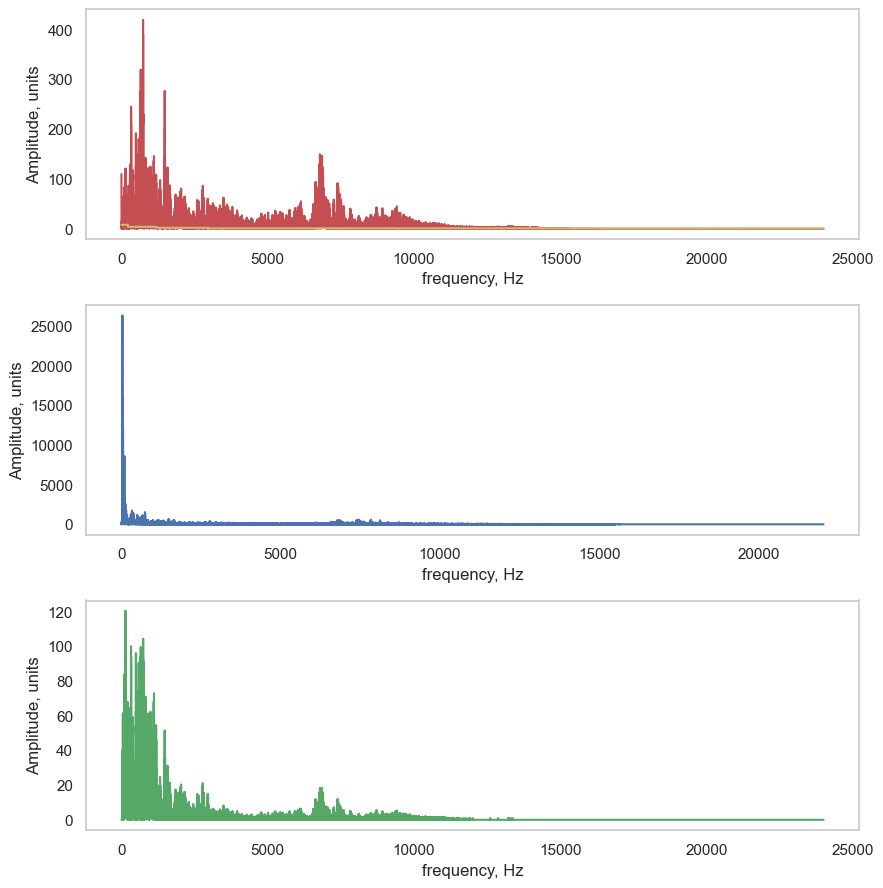

In [406]:
boost_audio('data/sample_2.wav', 'data/cut_original2.wav', 'data/noiseless_sample2_boosted1.wav', conv_freq_filter)

Converting to fft
Creating filter 229377
(229377,) [8 8 8 ... 1 1 1] 1
Filtering


<ipython-input-394-eec78af3fbf5>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)


plotting


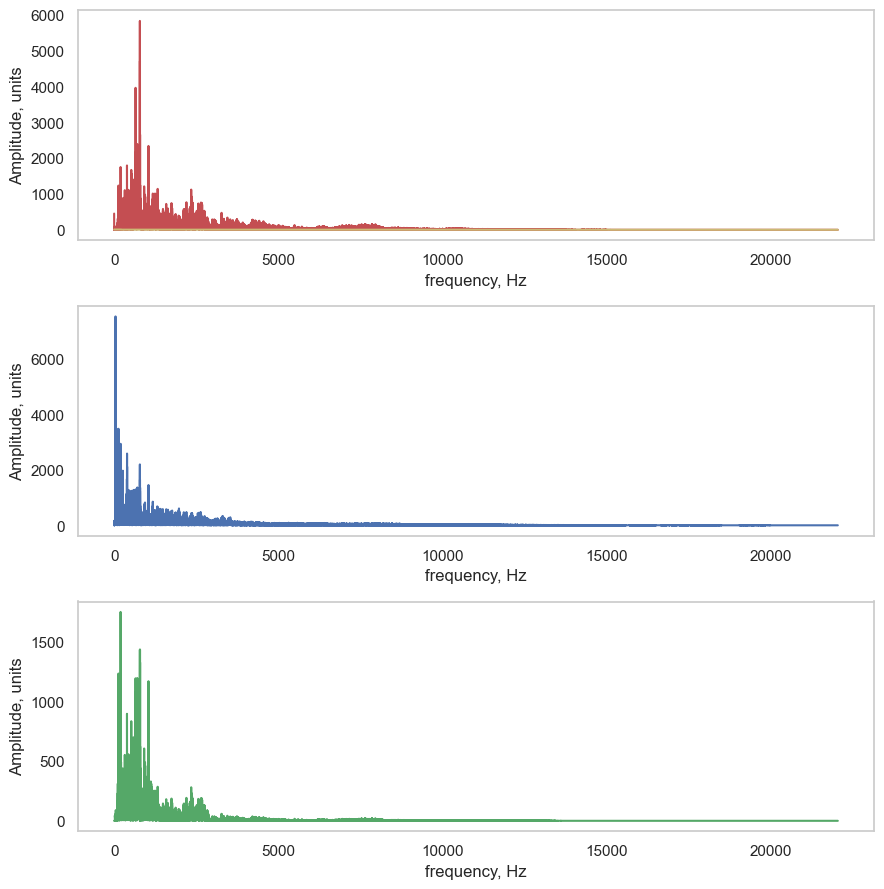

In [407]:
boost_audio('data/sample_3.wav', 'data/cut_original3.wav', 'data/noiseless_sample3_boosted1.wav', conv_freq_filter)

Converting to fft
Creating filter 229377
(229377,) [8 8 8 ... 1 1 1] 1
Filtering


<ipython-input-394-eec78af3fbf5>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)


plotting


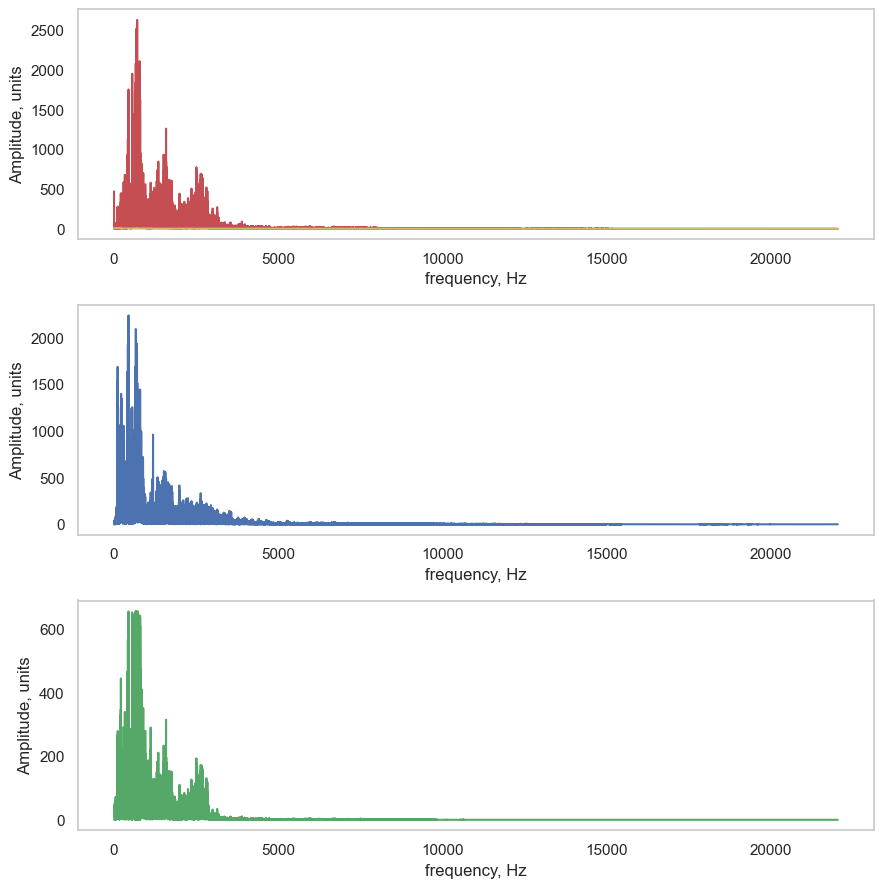

In [408]:
boost_audio('data/sample_4.wav', 'data/cut_original4.wav', 'data/noiseless_sample4_boosted1.wav', conv_freq_filter)

Converting to fft
Creating filter 229377
(229377,) [8 8 8 ... 1 1 1] 1
Filtering


<ipython-input-394-eec78af3fbf5>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)


plotting


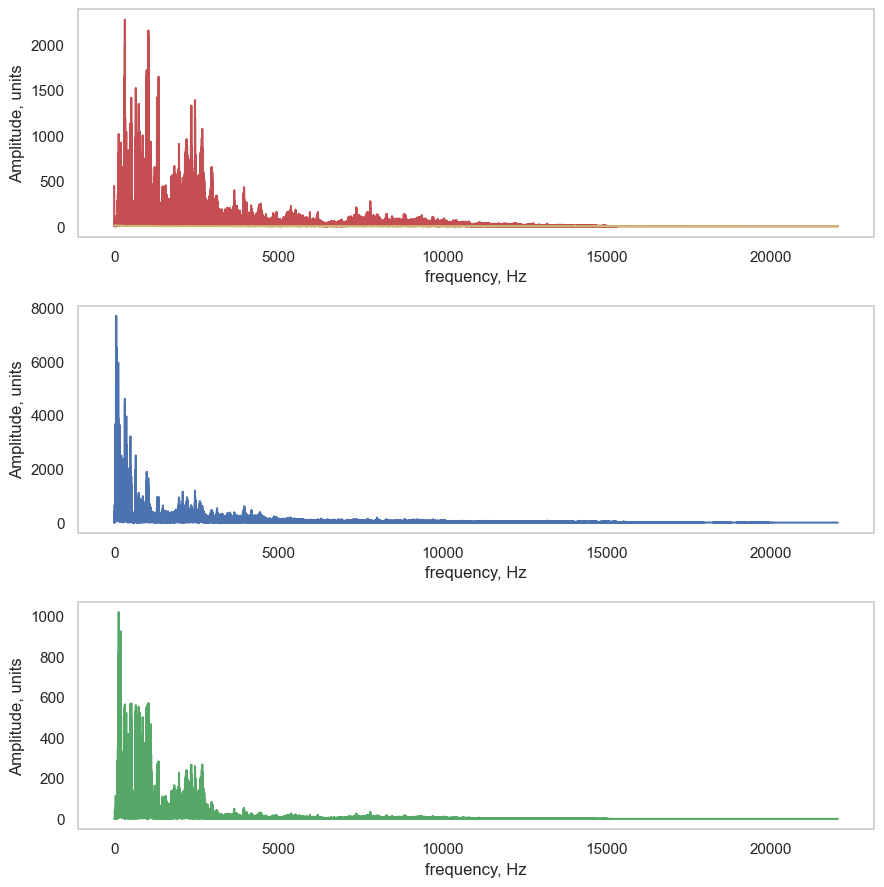

In [405]:
boost_audio('data/sample_5.wav', 'data/cut_original5.wav', 'data/noiseless_sample5_boosted1.wav', conv_freq_filter)

<ipython-input-255-2f3bc5975638>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)
<ipython-input-255-2f3bc5975638>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)
<ipython-input-255-2f3bc5975638>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)
<ipython-input-255-2f3bc5975638>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)
<ipython-input-255-2f3bc5975638>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampFreq, sound = wavfile.read(inp_filename)


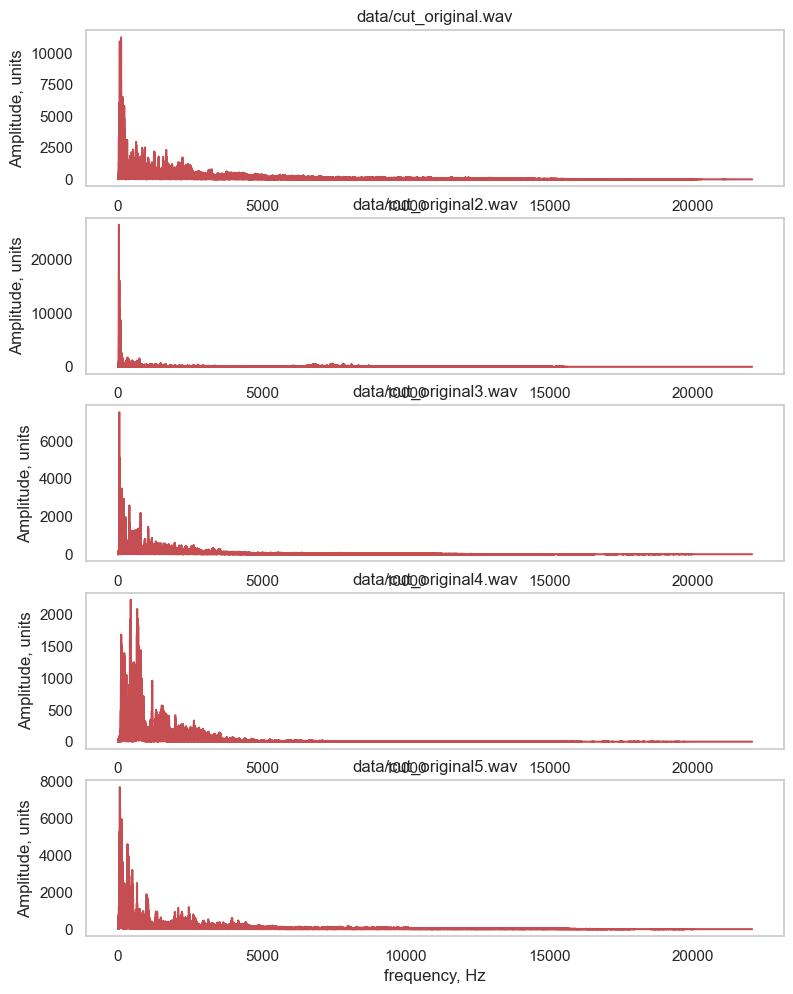

In [261]:
plot_frequencies(['data/cut_original.wav', 'data/cut_original2.wav', 'data/cut_original3.wav', 'data/cut_original4.wav', 'data/cut_original5.wav'])
                  

In [124]:
from pydub import AudioSegment
from os import listdir
import numpy as np
import math

song_dir = "songs"
attenuate_db = 0
accentuate_db = 2


def bass_line_freq(track):
    sample_track = list(track)

    # c-value
    est_mean = np.mean(sample_track)

    # a-value
    est_std = 3 * np.std(sample_track) / (math.sqrt(2))

    bass_factor = int(round((est_std - est_mean) * 0.005))

    return bass_factor

sample = AudioSegment.from_wav('data/sample_3.wav')
filtered = sample.low_pass_filter(bass_line_freq(sample.get_array_of_samples()))

combined = (sample - attenuate_db).overlay(filtered + accentuate_db)
combined.export('data/sample_3-export.wav', format="wav")


<_io.BufferedRandom name='data/sample_3-export.wav'>